In [96]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as sa
import scipy.linalg as la

In [97]:
df = pd.read_csv("Cleaned Datasets/US_Full_Quarterly.csv")

In [98]:
class OurKalmanFilter:
    def __init__(self, df, y, var1="Diff Log Dependency", var2="Diff Log Inv", yearSplit=2000, dim_x=1, dim_z = 1):
        self.yearSplit = yearSplit
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.df = df.copy()
        self.y = y
        self._formatData(var1, var2)
        self.var1 = var1
        self.var2 = var2

    def _formatData(self, var1="Diff Log Dependency", var2="Diff Log Inv"):
        self.df["Log GDP"] = np.log(self.df["GDP"])
        self.df['Diff Log GDP'] = self.df['Log GDP'] - self.df['Log GDP'].shift(1)
        self.df["Log Inv"] = np.log(self.df["Inv"])
        self.df["Diff Log Inv"] = self.df["Log Inv"] - self.df["Log Inv"].shift(1)
        self.df["Log Dependency"] = np.log(self.df["Dependency"])
        for i in range(1,4):
            self.df["Log Dependency"]+= np.log(self.df["Dependency"].shift(i))
        self.df["Log Dependency"] /= 4

        self.df["Diff Log Dependency"] = self.df["Log Dependency"] - self.df["Log Dependency"].shift(4)

        deflator = pd.read_csv("Cleaned Datasets/GDPDEF.csv",index_col = "DATE")
        self.df = self.df.join(deflator,on = "DATE", how = "inner")
        self.df["Real GDP"] = self.df["GDP"]/self.df["GDPDEF"]
        self.df["Real Inv"] = self.df["Inv"]/self.df["GDPDEF"]
        
        self.df.set_index("DATE", drop=True, inplace=True)
        self.df.dropna(inplace=True)

        if self.dim_x == 1:
            self.df = self.df[[self.y]]
        elif self.dim_x == 3:
            self.df = self.df[[self.y, var1, var2]]

        # Split the data into train and test
        self.trainingData = self.df[self.df.index <= str(self.yearSplit)]
        self.testingData = self.df[self.df.index > str(self.yearSplit)]
        return None
    
    def train(self, F, H):
        # Set initial parameters
        if self.dim_z == 1:
            self.zMatrix = self.trainingData[self.y].to_numpy()
        elif self.dim_z == 3:
            self.zMatrix = self.trainingData.to_numpy()
        self.Q = np.eye(self.dim_x)*.1
        self.R = np.eye(self.dim_z)*.1
        self.H = H
        df_ = self.df.to_numpy()
        self.x0 = df_[0] 
        X = F.ravel()

        X = minimize(self._likelihood, X, method="bfgs", tol=1e-8).x
        self.F = X.reshape(self.dim_x, self.dim_x)

        print(f"F: {self.F}")
        print(f"H: {self.H}")

        return None

    def _likelihood(self, X):
        # Unpack the values
        F = X.reshape(self.dim_x, self.dim_x)
    
        # Initialize appropriate parameters
        xhat = self.x0.copy().reshape(-1,1)
        Phat = np.eye(self.dim_x)*100
        logLikelis = []
        # Calculate the mean of z
        # mu = np.mean(self.zMatrix, axis=0)
        # Calculate the log-likelihood for each point.
        for i in range(self.zMatrix.shape[0]):
            # Predict the x value
            xhat = F@xhat
            
            # Predict the P value
            Phat = F@Phat@(F.T) + self.Q
            mean = self.H@xhat.reshape(-1)
            cov = self.H@Phat@(self.H.T) +self.R

            likelihood = np.log(sa.multivariate_normal.pdf(self.zMatrix[i], mean=mean, cov=cov, allow_singular=True))
            logLikelis.append(likelihood)

        return -1*np.sum(logLikelis)
    

    def fit_predict(self, stepsForward):
        f = KalmanFilter(dim_x=self.dim_x, dim_z=self.dim_z)
        f.x = self.x0.copy()
        f.F = self.F.copy()
        f.H = self.H.copy().reshape(self.dim_z,self.dim_x)
        f.Q = self.Q.copy()
        f.R = self.R.copy()

        self.xhat, Ps, self.z = self._predict(f, self.zMatrix, stepsForward)
        return None
    
    def _filter(self, f, zs):
        n = np.size(zs,0)
        # initialize
        xhat = np.zeros((n,f.dim_x,1))
        Ps = np.zeros((n,f.dim_x,f.dim_x))
        z_filtered = np.zeros((n,f.dim_z))
    
        for i,z in enumerate(zs):
            f.predict()
            f.update(z)
            xhat[i] = f.x.copy().reshape(-1, 1)
            Ps[i] = f.P.copy()
            z_filtered[i] = (f.H)@(xhat[i].reshape(f.dim_x,))
            
        return xhat, Ps, z_filtered

    def _predict(self, f, zs, stepsForward):
        xhat, Ps, z_filtered = self._filter(f, zs)
        xhat_predict = np.zeros((stepsForward, f.dim_x, 1))
        Ps_predict = np.zeros((stepsForward, f.dim_x, f.dim_x))
        z_predicts = np.zeros((stepsForward, f.dim_z))

        for i in range(stepsForward):
            f.predict()
            xhat_predict[i] = f.x.copy().reshape(-1, 1)
            Ps[i] = f.P.copy()
            z_predicts[i] = (f.H)@(xhat_predict[i].reshape(f.dim_x,))
        
        # TODO: We could also alter the function so that it saves the filtered and predicts separately
        return np.vstack((xhat, xhat_predict)), 0, np.vstack((z_filtered, z_predicts))
    
    def plotResults(self):
        # Plot the results
        self.df.index = pd.to_datetime(self.df.index).to_period(freq="D")
        self.trainingData.index = pd.to_datetime(self.trainingData.index).to_period(freq="D")
        self.testingData.index = pd.to_datetime(self.testingData.index).to_period(freq="D")
        if self.dim_z == 1:
            fig, axs = plt.subplots(1,self.dim_z,figsize=(10,5))
        elif self.dim_z:
            fig, axs = plt.subplots(1,self.dim_z,figsize=(15,5))

    
        def plot_z(given_z, i=None, column = None):
            if i == None:
                self.trainingData.plot(y=self.y, ax=axs, label="Training Data", use_index=True)
                self.testingData.plot(y=self.y, ax=axs, label="Testing Data", use_index=True)
                domain = pd.date_range(start=self.df.index[0].to_timestamp(), periods=given_z.size, freq="QS")
                axs.plot(domain, given_z, 'g--', label='filter estimates')

                # Manually set x-axis tick marks and labels for every 10 years
                start_date = pd.Timestamp(self.df.index.min().year, 1, 1).to_period(freq="D")
                end_date = pd.Timestamp(self.df.index.max().year, 1, 1).to_period(freq="D")
                tick_positions = pd.date_range(start=start_date.to_timestamp(), end=end_date.to_timestamp(), freq='10AS')
                tick_labels = [tick.strftime('%Y') for tick in tick_positions]
                axs.set_xticks(tick_positions, tick_labels)
                axs.set_title(self.y)
                axs.legend()
            else:
                self.trainingData.plot(y=column, ax=axs[i], label="Training Data", use_index=True)
                self.testingData.plot(y=column, ax=axs[i], label="Testing Data", use_index=True)
                domain = pd.date_range(start=self.df.index[0].to_timestamp(), periods=given_z.size, freq="QS")
                axs[i].plot(domain, given_z, 'g--', label='filter estimates')

                # Manually set x-axis tick marks and labels for every 10 years
                start_date = pd.Timestamp(self.df.index.min().year, 1, 1).to_period(freq="D")
                end_date = pd.Timestamp(self.df.index.max().year, 1, 1).to_period(freq="D")
                tick_positions = pd.date_range(start=start_date.to_timestamp(), end=end_date.to_timestamp(), freq='10AS')
                tick_labels = [tick.strftime('%Y') for tick in tick_positions]
                axs[i].set_xticks(tick_positions, tick_labels)
                axs[i].set_title(column)
                axs[i].legend()

        if self.dim_z == 1:
            plot_z(self.z)
            
        elif self.dim_z == 3:
            plot_z(self.z[:,0], 0, self.y)
            plot_z(self.z[:,1], 1, self.var1)
            plot_z(self.z[:,2], 2, self.var2)

        plt.grid()
        #plt.tight_layout()
        plt.savefig("V3_Kalman1d.png", dpi=300)


In [99]:
test1d = OurKalmanFilter(df, "Real GDP", yearSplit='2010', var1='Dependency', var2="Inv", dim_x=3, dim_z=1)
# F = np.array([[1.1, 0.1, 0.2],   # Influence of past values on consumption expenditure
#               [0.2, 1.1, 0.1],   # Influence of past values on investment expenditure
#               [0.1, 0.2, 1.1]])

F = np.eye(3)
# F = np.array([[1]])
# H = np.array([[1]])
# Measurement matrix H
H = np.ones(3)  # We observe the total GDP, which is the sum of the three components
test1d.train(F, H)
test1d.fit_predict(stepsForward=50)

F: [[  2.06120344 -15.03215901   5.28437628]
 [ -0.59831654   2.39354147  -1.14149936]
 [ -0.7891751   13.86127314  -3.62712956]]
H: [1. 1. 1.]


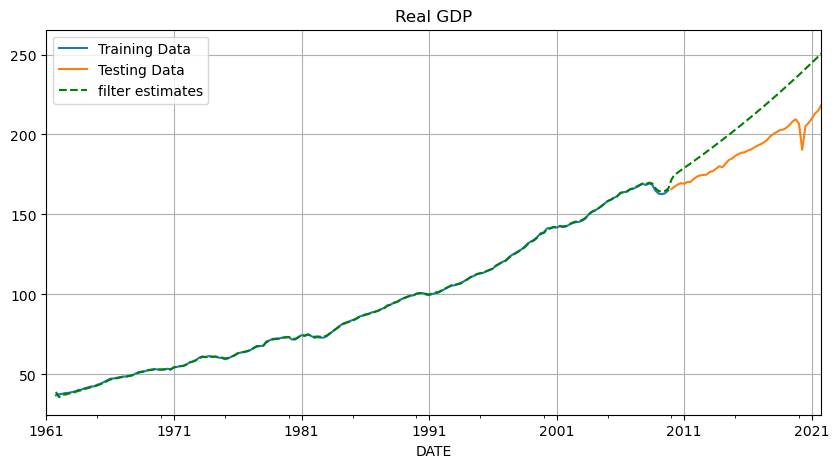

In [100]:
test1d.plotResults()

In [109]:

test1d = OurKalmanFilter(df, "Real GDP", yearSplit='2010', var1='Diff Log Dependency', var2="Diff Log Inv", dim_x=3, dim_z=3)
F = np.eye(3)*1.1 # Influence of past values on consumption expenditure
# F = np.array([[0.9, 0.1, 0.2],   # Influence of past values on consumption expenditure
#               [0.2, 0.8, 0.1],   # Influence of past values on investment expenditure
#               [0.1, 0.2, 0.9]])

# F = np.array([[2.06120344, -15.03215901, 5.28437628],
#                 [-0.59831654, 2.39354147, -1.14149936],
#                 [ -0.7891751, 13.86127314, -3.62712956]])


# Measurement matrix H
H = np.eye(3)  # We observe the total GDP, which is the sum of the three components
test1d.train(F, H)
test1d.fit_predict(stepsForward=50)

C:\Users\alexa\AppData\Local\Temp\ipykernel_2716\1940947272.py:83: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(sa.multivariate_normal.pdf(self.zMatrix[i], mean=mean, cov=cov, allow_singular=True))
c:\Users\alexa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\alexa\AppData\Local\Temp\ipykernel_2716\1940947272.py:83: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(sa.multivariate_normal.pdf(self.zMatrix[i], mean=mean, cov=cov, allow_singular=True))
C:\Users\alexa\AppData\Local\Temp\ipykernel_2716\1940947272.py:83: RuntimeWarning: divide by zero encountered in log
  likelihood = np.log(sa.multivariate_normal.pdf(self.zMatrix[i], mean=mean, cov=cov, allow_singular=True))
c:\Users\alexa\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\alexa\AppData\Local\

F: [[1.00797381e+00 3.31779817e-04 6.23949454e-04]
 [3.39846881e-05 7.24846726e-07 1.48807818e-06]
 [1.17256495e-04 1.50198531e-06 2.61556084e-06]]
H: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


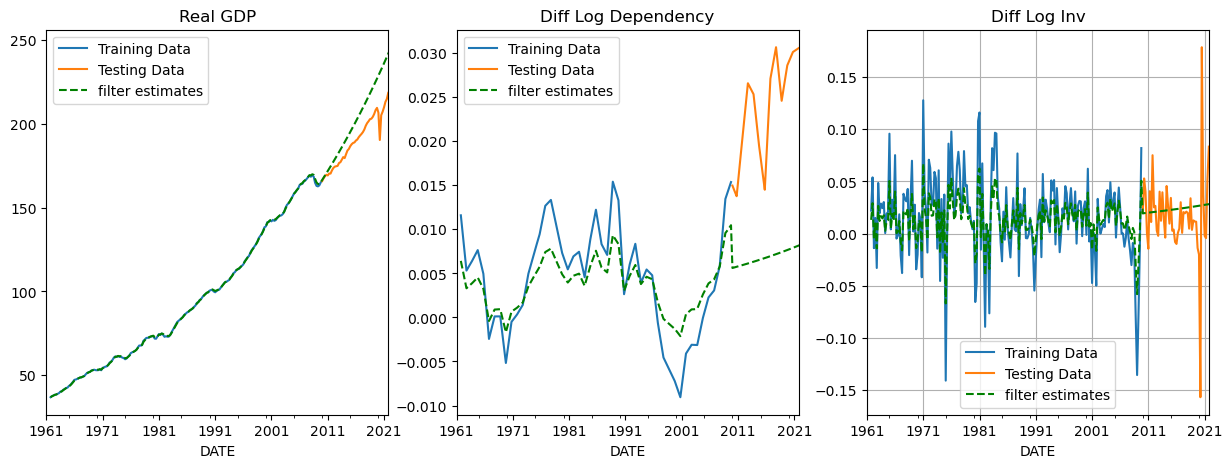

In [110]:
test1d.plotResults()

Clearly, the model doesn't generalize well to multiple dimensions